In [1]:
import numpy as np
from tqdm import tqdm
import os

from videograph import VideoGraph
from utils.general import *
from utils.video_processing import *
from utils.chat_api import *
from prompts import *

from face_processing import process_faces
from voice_processing import process_voices
from memory_processing import (
    process_captions,
    generate_captions_and_thinkings_with_ids,
)

/usr/local/lib/python3.9/dist-packages/bytedtrace/__init__.py:108: UserWarning: [bytedtrace] global tracer is already initialized.
  warnings.warn('[bytedtrace] global tracer is already initialized.')


In [2]:
def process_segment(video_graph, base64_video, base64_frames, base64_audio):

    id2voices = process_voices(video_graph, base64_audio, base64_video)
    print("Finish processing voices")

    # print(f"processing {len(base64_frames)} frames...")

    # id2faces = process_faces(video_graph, base64_frames)
    # # print(id2faces.keys())
    # print("Finish processing faces")

    # episodic_captions, semantic_captions = generate_captions_and_thinkings_with_ids(
    #     base64_video,
    #     base64_frames,
    #     base64_audio,
    #     id2faces,
    #     id2voices,
    # )

    # process_captions(video_graph, episodic_captions, type="episodic")
    # process_captions(video_graph, semantic_captions, type="semantic")

    print("Finish processing segment")


def streaming_process_video(
    video_graph, video_path, interval_seconds, fps, segment_limit=None
):
    """Process video segments at specified intervals with given fps.

    Args:
        video_graph (VideoGraph): Graph object to store video information
        video_path (str): Path to the video file or directory containing clips
        interval_seconds (float): Time interval between segments in seconds
        fps (float): Frames per second to extract from each segment

    Returns:
        None: Updates video_graph in place with processed segments
    """
    if os.path.isfile(video_path):
        # Process single video file
        video_info = get_video_info(video_path)
        print(video_info)

        # Process each interval
        count = 0
        for start_time in np.arange(0, video_info["duration"], interval_seconds):
            if start_time + interval_seconds > video_info["duration"]:
                break

            print("=" * 20)
            count += 1

            print(f"Loading {count}-th clip starting at {start_time} seconds...")
            base64_video, base64_frames, base64_audio = process_video_clip(
                video_path, start_time, interval_seconds, fps, audio_format="wav"
            )

            # check dtype
            # print(type(base64_video), type(base64_frames[0]), type(base64_audio))

            # Process frames for this interval
            if base64_frames:
                print(
                    f"Starting processing {count}-th clip starting at {start_time} seconds..."
                )
                process_segment(
                    video_graph,
                    base64_video,
                    base64_frames,
                    base64_audio,
                )

            if segment_limit is not None and count >= segment_limit:
                break

    elif os.path.isdir(video_path):
        # Process directory of numbered clips
        files = os.listdir(video_path)
        # Filter for video files and sort by numeric value in filename
        video_files = [
            f for f in files if any(f.endswith(ext) for ext in [".mp4", ".avi", ".mov"])
        ]
        video_files.sort(key=lambda x: int("".join(filter(str.isdigit, x))))

        for count, video_file in enumerate(video_files, 1):
            print("=" * 20)
            full_path = os.path.join(video_path, video_file)
            print(f"Processing clip {count}: {full_path}")

            base64_video, base64_frames, base64_audio = process_video_clip(
                full_path, 0, interval_seconds, fps, audio_format="wav"
            )

            if base64_frames:
                process_segment(
                    video_graph,
                    base64_video,
                    base64_frames,
                    base64_audio,
                )

            if segment_limit is not None and count >= segment_limit:
                break

Processing clip 1: data/videos/clipped/5 Poor People vs 1 Secret Millionaire/1.mp4
{'video_found': True, 'audio_found': True, 'metadata': {'major_brand': 'isom', 'minor_version': '512', 'compatible_brands': 'isomiso2avc1mp41', 'encoder': 'Lavf61.1.100'}, 'inputs': [{'streams': [{'input_number': 0, 'stream_number': 0, 'stream_type': 'video', 'language': None, 'default': True, 'size': [1280, 720], 'bitrate': 1044, 'fps': 23.976023976023978, 'codec_name': 'h264', 'profile': '(High)', 'metadata': {'Metadata': '', 'handler_name': 'VideoHandler', 'vendor_id': '[0][0][0][0]', 'encoder': 'Lavc61.3.100 libx264'}}, {'input_number': 0, 'stream_number': 1, 'stream_type': 'audio', 'language': None, 'default': True, 'fps': 44100, 'bitrate': 129, 'metadata': {'Metadata': '', 'handler_name': 'SoundHandler', 'vendor_id': '[0][0][0][0]'}}], 'input_number': 0}], 'duration': 30.0, 'bitrate': 1179, 'start': 0.0, 'default_video_input_number': 0, 'default_video_stream_number': 0, 'video_codec_name': 'h264', 

{'video_found': True, 'audio_found': True, 'metadata': {'major_brand': 'isom', 'minor_version': '512', 'compatible_brands': 'isomiso2avc1mp41', 'encoder': 'Lavf61.1.100'}, 'inputs': [{'streams': [{'input_number': 0, 'stream_number': 0, 'stream_type': 'video', 'language': None, 'default': True, 'size': [1280, 720], 'bitrate': 1044, 'fps': 23.976023976023978, 'codec_name': 'h264', 'profile': '(High)', 'metadata': {'Metadata': '', 'handler_name': 'VideoHandler', 'vendor_id': '[0][0][0][0]', 'encoder': 'Lavc61.3.100 libx264'}}, {'input_number': 0, 'stream_number': 1, 'stream_type': 'audio', 'language': None, 'default': True, 'fps': 44100, 'bitrate': 129, 'metadata': {'Metadata': '', 'handler_name': 'SoundHandler', 'vendor_id': '[0][0][0][0]'}}], 'input_number': 0}], 'duration': 30.0, 'bitrate': 1179, 'start': 0.0, 'default_video_input_number': 0, 'default_video_stream_number': 0, 'video_codec_name': 'h264', 'video_profile': '(High)', 'video_size': [1280, 720], 'video_bitrate': 1044, 'video

2025-03-25 03:53:50,703 - httpx - INFO - HTTP Request: POST https://search-va.byteintl.net/gpt/openapi/online/multimodal/crawl/openai/deployments/gemini-1.5-pro-002/chat/completions?api-version=2024-03-01-preview "HTTP/1.1 200 OK"


[{'start_time': '00:00', 'end_time': '00:03', 'speaker': '<speaker_1>', 'asr': "We got Denny, Herm, Aaron and JC and five people who say they're millionaire.", 'duration': 3}, {'start_time': '00:06', 'end_time': '00:08', 'speaker': '<speaker_1>', 'asr': "But only one of them is and the other four are lying. Let's just start by just appearances.", 'duration': 2}, {'start_time': '00:10', 'end_time': '00:11', 'speaker': '<speaker_2>', 'asr': 'Okay.', 'duration': 1}, {'start_time': '00:11', 'end_time': '00:11', 'speaker': '<speaker_3>', 'asr': "You're broke.", 'duration': 0}, {'start_time': '00:13', 'end_time': '00:15', 'speaker': '<speaker_3>', 'asr': 'Got bills.', 'duration': 2}, {'start_time': '00:15', 'end_time': '00:15', 'speaker': '<speaker_4>', 'asr': 'Got bills.', 'duration': 0}, {'start_time': '00:16', 'end_time': '00:18', 'speaker': '<speaker_2>', 'asr': "That's not right. That's not right, bro.", 'duration': 2}, {'start_time': '00:18', 'end_time': '00:21', 'speaker': '<speaker_3

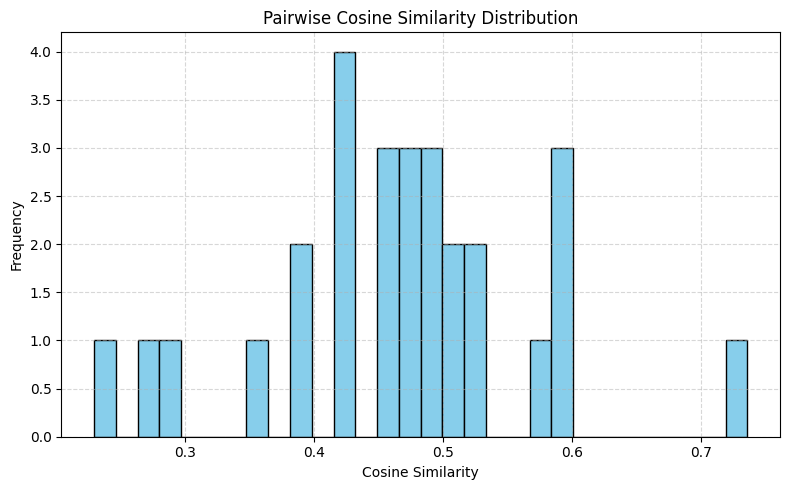

Voice node added with ID 0
Voice node added with ID 1
Voice node added with ID 2
Finish processing voices
Finish processing segment
Processing clip 2: data/videos/clipped/5 Poor People vs 1 Secret Millionaire/2.mp4
{'video_found': True, 'audio_found': True, 'metadata': {'major_brand': 'isom', 'minor_version': '512', 'compatible_brands': 'isomiso2avc1mp41', 'encoder': 'Lavf61.1.100'}, 'inputs': [{'streams': [{'input_number': 0, 'stream_number': 0, 'stream_type': 'video', 'language': None, 'default': True, 'size': [1280, 720], 'bitrate': 769, 'fps': 23.976023976023978, 'codec_name': 'h264', 'profile': '(High)', 'metadata': {'Metadata': '', 'handler_name': 'VideoHandler', 'vendor_id': '[0][0][0][0]', 'encoder': 'Lavc61.3.100 libx264'}}, {'input_number': 0, 'stream_number': 1, 'stream_type': 'audio', 'language': None, 'default': True, 'fps': 44100, 'bitrate': 128, 'metadata': {'Metadata': '', 'handler_name': 'SoundHandler', 'vendor_id': '[0][0][0][0]'}}], 'input_number': 0}], 'duration': 3

2025-03-25 03:54:18,290 - httpx - INFO - HTTP Request: POST https://search-va.byteintl.net/gpt/openapi/online/multimodal/crawl/openai/deployments/gemini-1.5-pro-002/chat/completions?api-version=2024-03-01-preview "HTTP/1.1 200 OK"


[{'start_time': '00:00', 'end_time': '00:05', 'speaker': '<speaker_1>', 'asr': "means he got a lot of money. And he got penny loafers on with no penny in it. So it's like, y'all don't even know how much I got. You know what I'm saying?", 'duration': 5}, {'start_time': '00:06', 'end_time': '00:06', 'speaker': '<speaker_2>', 'asr': 'So a lot.', 'duration': 0}, {'start_time': '00:07', 'end_time': '00:10', 'speaker': '<speaker_1>', 'asr': "But then again, millionaires don't dress up.", 'duration': 3}, {'start_time': '00:10', 'end_time': '00:17', 'speaker': '<speaker_3>', 'asr': "They really wear like like four, three and four, very like calm, because they don't make you know, they don't", 'duration': 7}, {'start_time': '00:16', 'end_time': '00:17', 'speaker': '<speaker_1>', 'asr': 'stress themselves out.', 'duration': 1}, {'start_time': '00:17', 'end_time': '00:18', 'speaker': '<speaker_3>', 'asr': "You don't look like he's drifted that. He looks a little bit too well put together, I would

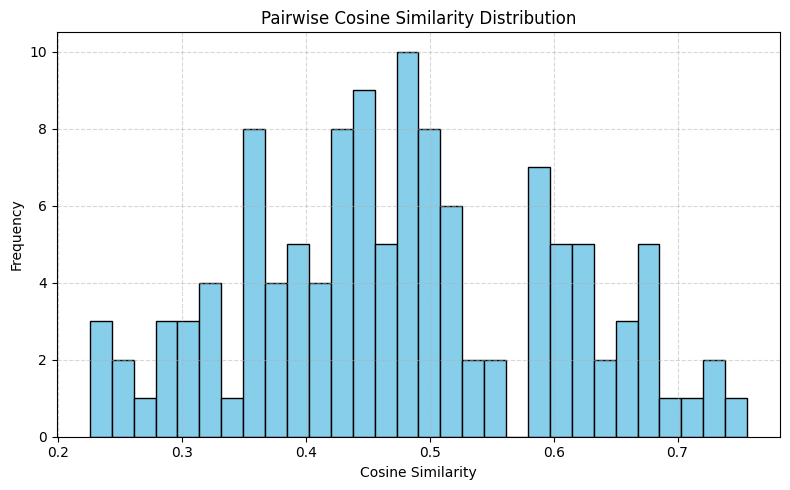

Embeddings added to node 2
Embeddings added to node 2
Embeddings added to node 2
Finish processing voices
Finish processing segment
Processing clip 3: data/videos/clipped/5 Poor People vs 1 Secret Millionaire/3.mp4
{'video_found': True, 'audio_found': True, 'metadata': {'major_brand': 'isom', 'minor_version': '512', 'compatible_brands': 'isomiso2avc1mp41', 'encoder': 'Lavf61.1.100'}, 'inputs': [{'streams': [{'input_number': 0, 'stream_number': 0, 'stream_type': 'video', 'language': None, 'default': True, 'size': [1280, 720], 'bitrate': 966, 'fps': 23.976023976023978, 'codec_name': 'h264', 'profile': '(High)', 'metadata': {'Metadata': '', 'handler_name': 'VideoHandler', 'vendor_id': '[0][0][0][0]', 'encoder': 'Lavc61.3.100 libx264'}}, {'input_number': 0, 'stream_number': 1, 'stream_type': 'audio', 'language': None, 'default': True, 'fps': 44100, 'bitrate': 128, 'metadata': {'Metadata': '', 'handler_name': 'SoundHandler', 'vendor_id': '[0][0][0][0]'}}], 'input_number': 0}], 'duration': 3

2025-03-25 03:54:44,662 - httpx - INFO - HTTP Request: POST https://search-va.byteintl.net/gpt/openapi/online/multimodal/crawl/openai/deployments/gemini-1.5-pro-002/chat/completions?api-version=2024-03-01-preview "HTTP/1.1 200 OK"


[{'start_time': '00:00', 'end_time': '00:01', 'speaker': '<speaker_1>', 'asr': 'Gazing?', 'duration': 1}, {'start_time': '00:01', 'end_time': '00:03', 'speaker': '<speaker_2>', 'asr': "I feel like you're gazing.", 'duration': 2}, {'start_time': '00:03', 'end_time': '00:07', 'speaker': '<speaker_3>', 'asr': 'No, I meant I meant I meant', 'duration': 4}, {'start_time': '00:07', 'end_time': '00:10', 'speaker': '<speaker_3>', 'asr': "I just meant where What's the English word for we're like not paying attention to?", 'duration': 3}, {'start_time': '00:10', 'end_time': '00:11', 'speaker': '<speaker_2>', 'asr': 'Oh, okay.', 'duration': 1}, {'start_time': '00:11', 'end_time': '00:13', 'speaker': '<speaker_4>', 'asr': "Oh, you mean, like, we're overlooking We're overlooking", 'duration': 2}, {'start_time': '00:14', 'end_time': '00:20', 'speaker': '<speaker_4>', 'asr': 'But I will say this, you look very well put together. I like the sparkles. She look like she may have new money.', 'duration':

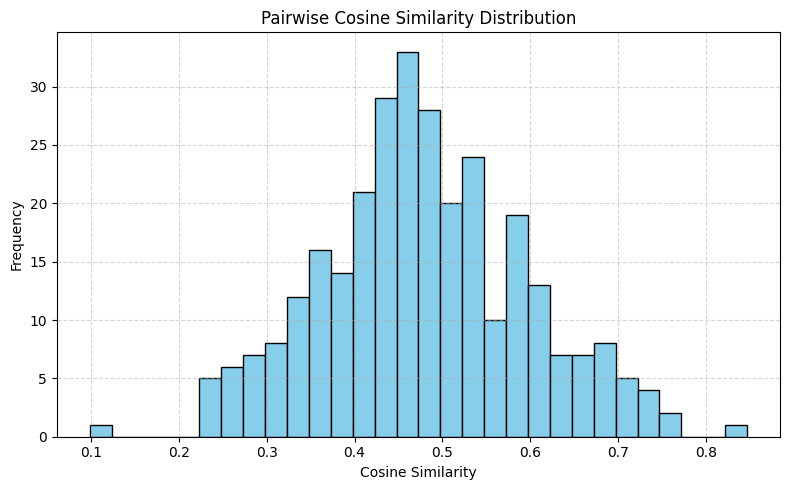

Voice node added with ID 3
Voice node added with ID 4
Voice node added with ID 5
Embeddings added to node 2
Voice node added with ID 6
Finish processing voices
Finish processing segment
Processing clip 4: data/videos/clipped/5 Poor People vs 1 Secret Millionaire/4.mp4
{'video_found': True, 'audio_found': True, 'metadata': {'major_brand': 'isom', 'minor_version': '512', 'compatible_brands': 'isomiso2avc1mp41', 'encoder': 'Lavf61.1.100'}, 'inputs': [{'streams': [{'input_number': 0, 'stream_number': 0, 'stream_type': 'video', 'language': None, 'default': True, 'size': [1280, 720], 'bitrate': 1102, 'fps': 23.976023976023978, 'codec_name': 'h264', 'profile': '(High)', 'metadata': {'Metadata': '', 'handler_name': 'VideoHandler', 'vendor_id': '[0][0][0][0]', 'encoder': 'Lavc61.3.100 libx264'}}, {'input_number': 0, 'stream_number': 1, 'stream_type': 'audio', 'language': None, 'default': True, 'fps': 44100, 'bitrate': 127, 'metadata': {'Metadata': '', 'handler_name': 'SoundHandler', 'vendor_id'

2025-03-25 03:55:12,023 - httpx - INFO - HTTP Request: POST https://search-va.byteintl.net/gpt/openapi/online/multimodal/crawl/openai/deployments/gemini-1.5-pro-002/chat/completions?api-version=2024-03-01-preview "HTTP/1.1 200 OK"


[{'start_time': '00:00', 'end_time': '00:01', 'speaker': '<speaker_1>', 'asr': 'fashion designer.', 'duration': 1}, {'start_time': '00:01', 'end_time': '00:02', 'speaker': '<speaker_2>', 'asr': "Oh, dope. Wow. That's dope.", 'duration': 1}, {'start_time': '00:03', 'end_time': '00:05', 'speaker': '<speaker_3>', 'asr': "Uh, I'm Tori K. and, uh, my family works in the oil business.", 'duration': 2}, {'start_time': '00:06', 'end_time': '00:12', 'speaker': '<speaker_2>', 'asr': 'Oh my god! She said she said her family! Hold on! She said her family! She said her family!', 'duration': 6}, {'start_time': '00:13', 'end_time': '00:14', 'speaker': '<speaker_2>', 'asr': 'Yeah, but white people share their wealth.', 'duration': 1}, {'start_time': '00:15', 'end_time': '00:15', 'speaker': '<speaker_4>', 'asr': 'Number three.', 'duration': 0}, {'start_time': '00:16', 'end_time': '00:18', 'speaker': '<speaker_5>', 'asr': 'Look like an African prince.', 'duration': 2}, {'start_time': '00:18', 'end_time'

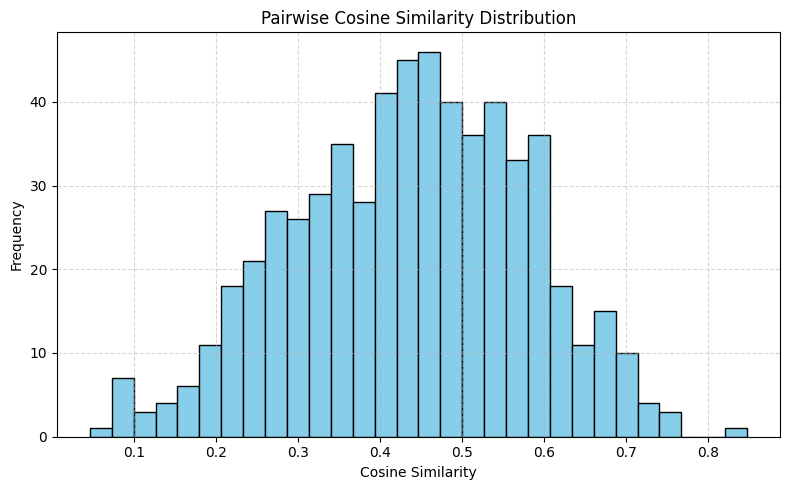

Embeddings added to node 5
Voice node added with ID 7
Embeddings added to node 5
Voice node added with ID 8
Finish processing voices
Finish processing segment
Processing clip 5: data/videos/clipped/5 Poor People vs 1 Secret Millionaire/5.mp4
{'video_found': True, 'audio_found': True, 'metadata': {'major_brand': 'isom', 'minor_version': '512', 'compatible_brands': 'isomiso2avc1mp41', 'encoder': 'Lavf61.1.100'}, 'inputs': [{'streams': [{'input_number': 0, 'stream_number': 0, 'stream_type': 'video', 'language': None, 'default': True, 'size': [1280, 720], 'bitrate': 905, 'fps': 23.976023976023978, 'codec_name': 'h264', 'profile': '(High)', 'metadata': {'Metadata': '', 'handler_name': 'VideoHandler', 'vendor_id': '[0][0][0][0]', 'encoder': 'Lavc61.3.100 libx264'}}, {'input_number': 0, 'stream_number': 1, 'stream_type': 'audio', 'language': None, 'default': True, 'fps': 44100, 'bitrate': 129, 'metadata': {'Metadata': '', 'handler_name': 'SoundHandler', 'vendor_id': '[0][0][0][0]'}}], 'input_

2025-03-25 03:55:39,806 - httpx - INFO - HTTP Request: POST https://search-va.byteintl.net/gpt/openapi/online/multimodal/crawl/openai/deployments/gemini-1.5-pro-002/chat/completions?api-version=2024-03-01-preview "HTTP/1.1 200 OK"


[{'start_time': '00:03', 'end_time': '00:05', 'speaker': '<speaker_1>', 'asr': 'What do you do for a living, Labone?', 'duration': 2}, {'start_time': '00:05', 'end_time': '00:08', 'speaker': '<speaker_2>', 'asr': "Uh, I'm a creative.", 'duration': 3}, {'start_time': '00:08', 'end_time': '00:10', 'speaker': '<speaker_1>', 'asr': 'Okay. He might miss.', 'duration': 2}, {'start_time': '00:10', 'end_time': '00:11', 'speaker': '<speaker_3>', 'asr': 'He might be broke.', 'duration': 1}, {'start_time': '00:11', 'end_time': '00:12', 'speaker': '<speaker_1>', 'asr': 'Did you name yourself Labone?', 'duration': 1}, {'start_time': '00:12', 'end_time': '00:13', 'speaker': '<speaker_3>', 'asr': 'He might be.', 'duration': 1}, {'start_time': '00:13', 'end_time': '00:16', 'speaker': '<speaker_2>', 'asr': "Yeah, yeah, it's, uh, my OnlyFans handle.", 'duration': 3}, {'start_time': '00:16', 'end_time': '00:17', 'speaker': '<speaker_1>', 'asr': 'Oh!', 'duration': 1}, {'start_time': '00:17', 'end_time': '

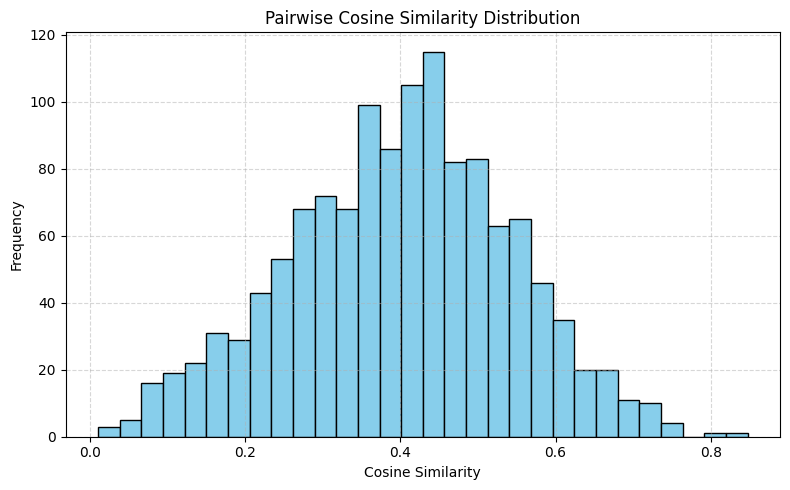

Voice node added with ID 9
Embeddings added to node 8
Voice node added with ID 10
Voice node added with ID 11
Finish processing voices
Finish processing segment
Processing clip 6: data/videos/clipped/5 Poor People vs 1 Secret Millionaire/6.mp4
{'video_found': True, 'audio_found': True, 'metadata': {'major_brand': 'isom', 'minor_version': '512', 'compatible_brands': 'isomiso2avc1mp41', 'encoder': 'Lavf61.1.100'}, 'inputs': [{'streams': [{'input_number': 0, 'stream_number': 0, 'stream_type': 'video', 'language': None, 'default': True, 'size': [1280, 720], 'bitrate': 965, 'fps': 23.976023976023978, 'codec_name': 'h264', 'profile': '(High)', 'metadata': {'Metadata': '', 'handler_name': 'VideoHandler', 'vendor_id': '[0][0][0][0]', 'encoder': 'Lavc61.3.100 libx264'}}, {'input_number': 0, 'stream_number': 1, 'stream_type': 'audio', 'language': None, 'default': True, 'fps': 44100, 'bitrate': 129, 'metadata': {'Metadata': '', 'handler_name': 'SoundHandler', 'vendor_id': '[0][0][0][0]'}}], 'inpu

2025-03-25 03:56:11,371 - httpx - INFO - HTTP Request: POST https://search-va.byteintl.net/gpt/openapi/online/multimodal/crawl/openai/deployments/gemini-1.5-pro-002/chat/completions?api-version=2024-03-01-preview "HTTP/1.1 200 OK"


[{'start_time': '00:00', 'end_time': '00:01', 'speaker': '<speaker_1>', 'asr': 'You can make a lot of money as a professor.', 'duration': 1}, {'start_time': '00:01', 'end_time': '00:02', 'speaker': '<speaker_2>', 'asr': 'Professor?', 'duration': 1}, {'start_time': '00:02', 'end_time': '00:03', 'speaker': '<speaker_3>', 'asr': 'Yeah, you got tenure.', 'duration': 1}, {'start_time': '00:03', 'end_time': '00:08', 'speaker': '<speaker_3>', 'asr': "Pete's trying to convince us. Yes! Tenure. Yo, yo, yo! Tenure. You got tenure. Professor of what?", 'duration': 5}, {'start_time': '00:09', 'end_time': '00:09', 'speaker': '<speaker_1>', 'asr': 'I teach Spanish.', 'duration': 0}, {'start_time': '00:10', 'end_time': '00:10', 'speaker': '<speaker_3>', 'asr': 'Spanish?', 'duration': 0}, {'start_time': '00:12', 'end_time': '00:13', 'speaker': '<speaker_3>', 'asr': 'What school?', 'duration': 1}, {'start_time': '00:13', 'end_time': '00:14', 'speaker': '<speaker_1>', 'asr': 'I teach at UCLA.', 'duratio

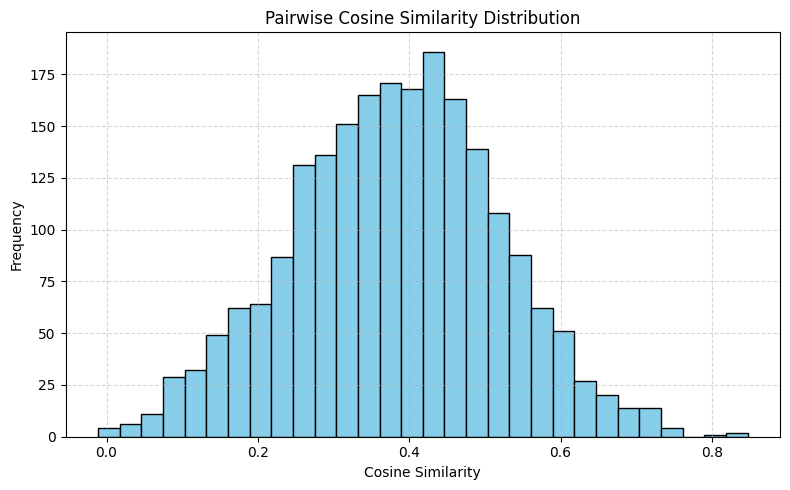

Voice node added with ID 12
Voice node added with ID 13
Voice node added with ID 14
Finish processing voices
Finish processing segment
Processing clip 7: data/videos/clipped/5 Poor People vs 1 Secret Millionaire/7.mp4
{'video_found': True, 'audio_found': True, 'metadata': {'major_brand': 'isom', 'minor_version': '512', 'compatible_brands': 'isomiso2avc1mp41', 'encoder': 'Lavf61.1.100'}, 'inputs': [{'streams': [{'input_number': 0, 'stream_number': 0, 'stream_type': 'video', 'language': None, 'default': True, 'size': [1280, 720], 'bitrate': 825, 'fps': 23.976023976023978, 'codec_name': 'h264', 'profile': '(High)', 'metadata': {'Metadata': '', 'handler_name': 'VideoHandler', 'vendor_id': '[0][0][0][0]', 'encoder': 'Lavc61.3.100 libx264'}}, {'input_number': 0, 'stream_number': 1, 'stream_type': 'audio', 'language': None, 'default': True, 'fps': 44100, 'bitrate': 128, 'metadata': {'Metadata': '', 'handler_name': 'SoundHandler', 'vendor_id': '[0][0][0][0]'}}], 'input_number': 0}], 'duration'

2025-03-25 03:56:40,126 - httpx - INFO - HTTP Request: POST https://search-va.byteintl.net/gpt/openapi/online/multimodal/crawl/openai/deployments/gemini-1.5-pro-002/chat/completions?api-version=2024-03-01-preview "HTTP/1.1 200 OK"


[{'start_time': '00:00', 'end_time': '00:01', 'speaker': '<speaker_1>', 'asr': 'and index funds.', 'duration': 1}, {'start_time': '00:01', 'end_time': '00:03', 'speaker': '<speaker_2>', 'asr': "I think he did. He's rich and you better be careful.", 'duration': 2}, {'start_time': '00:04', 'end_time': '00:06', 'speaker': '<speaker_3>', 'asr': 'Bitcoin has been a little bit on the on the rocker recently.', 'duration': 2}, {'start_time': '00:06', 'end_time': '00:09', 'speaker': '<speaker_4>', 'asr': "Yeah. It's not great, but I got out before it the bed.", 'duration': 3}, {'start_time': '00:11', 'end_time': '00:12', 'speaker': '<speaker_2>', 'asr': 'Name three index funds right now.', 'duration': 1}, {'start_time': '00:13', 'end_time': '00:15', 'speaker': '<speaker_4>', 'asr': "Uh, most of my money's in Vanguard, honestly.", 'duration': 2}, {'start_time': '00:15', 'end_time': '00:17', 'speaker': '<speaker_1>', 'asr': "Whoa! Kevin, don't even act like you know what he talking.", 'duration':

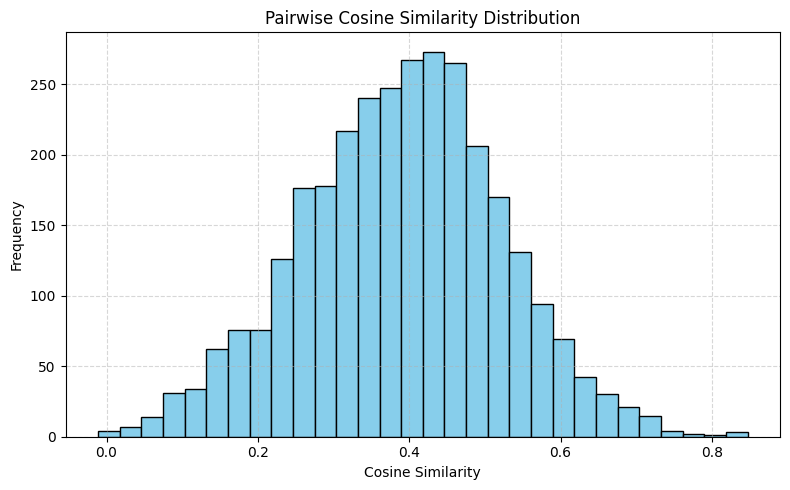

Voice node added with ID 15
Embeddings added to node 10
Embeddings added to node 5
Embeddings added to node 14
Embeddings added to node 7
Finish processing voices
Finish processing segment
Processing clip 8: data/videos/clipped/5 Poor People vs 1 Secret Millionaire/8.mp4
{'video_found': True, 'audio_found': True, 'metadata': {'major_brand': 'isom', 'minor_version': '512', 'compatible_brands': 'isomiso2avc1mp41', 'encoder': 'Lavf61.1.100'}, 'inputs': [{'streams': [{'input_number': 0, 'stream_number': 0, 'stream_type': 'video', 'language': None, 'default': True, 'size': [1280, 720], 'bitrate': 804, 'fps': 23.976023976023978, 'codec_name': 'h264', 'profile': '(High)', 'metadata': {'Metadata': '', 'handler_name': 'VideoHandler', 'vendor_id': '[0][0][0][0]', 'encoder': 'Lavc61.3.100 libx264'}}, {'input_number': 0, 'stream_number': 1, 'stream_type': 'audio', 'language': None, 'default': True, 'fps': 44100, 'bitrate': 130, 'metadata': {'Metadata': '', 'handler_name': 'SoundHandler', 'vendor_i

2025-03-25 03:57:06,015 - httpx - INFO - HTTP Request: POST https://search-va.byteintl.net/gpt/openapi/online/multimodal/crawl/openai/deployments/gemini-1.5-pro-002/chat/completions?api-version=2024-03-01-preview "HTTP/1.1 200 OK"


[{'start_time': '00:00', 'end_time': '00:03', 'speaker': '<speaker_1>', 'asr': 'So do do you work at a job? You just make you do music full time?', 'duration': 3}, {'start_time': '00:03', 'end_time': '00:05', 'speaker': '<speaker_2>', 'asr': 'Uh, I do music. I also work in advertising.', 'duration': 2}, {'start_time': '00:05', 'end_time': '00:09', 'speaker': '<speaker_1>', 'asr': 'Did you make your money or you you got like a trust fund?', 'duration': 4}, {'start_time': '00:09', 'end_time': '00:15', 'speaker': '<speaker_2>', 'asr': 'Trust fund from my family, but I also like grew from grew up from a young age wanting to be an entrepreneur and do my own.', 'duration': 6}, {'start_time': '00:16', 'end_time': '00:21', 'speaker': '<speaker_2>', 'asr': "So, my family's actually from Texas, but I moved up to LA to do advertising and music, so yeah.", 'duration': 5}, {'start_time': '00:21', 'end_time': '00:23', 'speaker': '<speaker_1>', 'asr': "You're so well spoken. I don't believe her.", 'd

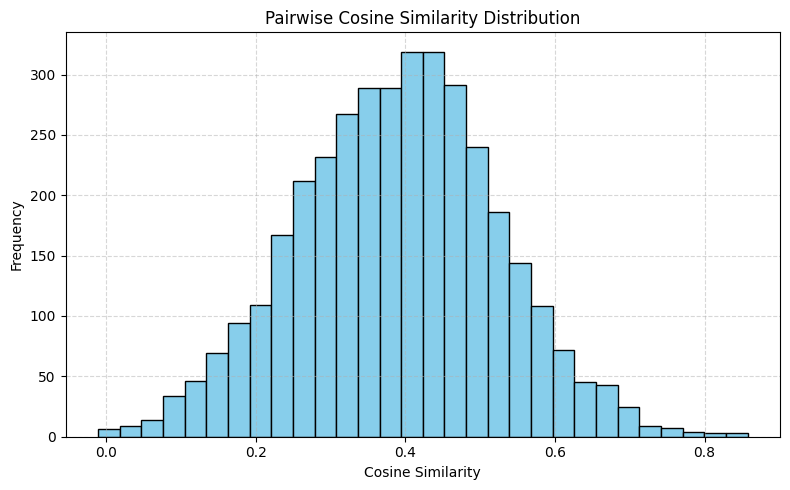

Embeddings added to node 5
Embeddings added to node 7
Finish processing voices
Finish processing segment
Processing clip 9: data/videos/clipped/5 Poor People vs 1 Secret Millionaire/9.mp4
{'video_found': True, 'audio_found': True, 'metadata': {'major_brand': 'isom', 'minor_version': '512', 'compatible_brands': 'isomiso2avc1mp41', 'encoder': 'Lavf61.1.100'}, 'inputs': [{'streams': [{'input_number': 0, 'stream_number': 0, 'stream_type': 'video', 'language': None, 'default': True, 'size': [1280, 720], 'bitrate': 898, 'fps': 23.976023976023978, 'codec_name': 'h264', 'profile': '(High)', 'metadata': {'Metadata': '', 'handler_name': 'VideoHandler', 'vendor_id': '[0][0][0][0]', 'encoder': 'Lavc61.3.100 libx264'}}, {'input_number': 0, 'stream_number': 1, 'stream_type': 'audio', 'language': None, 'default': True, 'fps': 44100, 'bitrate': 128, 'metadata': {'Metadata': '', 'handler_name': 'SoundHandler', 'vendor_id': '[0][0][0][0]'}}], 'input_number': 0}], 'duration': 30.0, 'bitrate': 1033, 'star

2025-03-25 03:57:37,630 - httpx - INFO - HTTP Request: POST https://search-va.byteintl.net/gpt/openapi/online/multimodal/crawl/openai/deployments/gemini-1.5-pro-002/chat/completions?api-version=2024-03-01-preview "HTTP/1.1 200 OK"


[{'start_time': '00:00', 'end_time': '00:01', 'speaker': '<speaker_1>', 'asr': 'It sounds like you work.', 'duration': 1}, {'start_time': '00:01', 'end_time': '00:03', 'speaker': '<speaker_2>', 'asr': "Well, you haven't met me so.", 'duration': 2}, {'start_time': '00:05', 'end_time': '00:06', 'speaker': '<speaker_3>', 'asr': 'You talk your', 'duration': 1}, {'start_time': '00:07', 'end_time': '00:08', 'speaker': '<speaker_4>', 'asr': "Also she's from", 'duration': 1}, {'start_time': '00:08', 'end_time': '00:09', 'speaker': '<speaker_2>', 'asr': 'Have you met anyone Southern?', 'duration': 1}, {'start_time': '00:09', 'end_time': '00:10', 'speaker': '<speaker_4>', 'asr': 'Yes, she got', 'duration': 1}, {'start_time': '00:10', 'end_time': '00:12', 'speaker': '<speaker_3>', 'asr': 'Hold on, I got you girl, I got you. Sorry.', 'duration': 2}, {'start_time': '00:12', 'end_time': '00:13', 'speaker': '<speaker_3>', 'asr': "She's from Texas.", 'duration': 1}, {'start_time': '00:13', 'end_time':

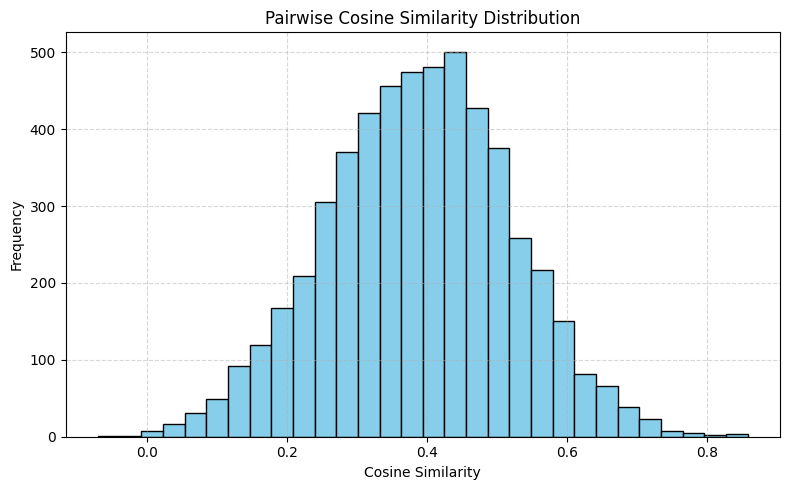

Embeddings added to node 7
Voice node added with ID 16
Finish processing voices
Finish processing segment
Processing clip 10: data/videos/clipped/5 Poor People vs 1 Secret Millionaire/10.mp4
{'video_found': True, 'audio_found': True, 'metadata': {'major_brand': 'isom', 'minor_version': '512', 'compatible_brands': 'isomiso2avc1mp41', 'encoder': 'Lavf61.1.100'}, 'inputs': [{'streams': [{'input_number': 0, 'stream_number': 0, 'stream_type': 'video', 'language': None, 'default': True, 'size': [1280, 720], 'bitrate': 591, 'fps': 23.976023976023978, 'codec_name': 'h264', 'profile': '(High)', 'metadata': {'Metadata': '', 'handler_name': 'VideoHandler', 'vendor_id': '[0][0][0][0]', 'encoder': 'Lavc61.3.100 libx264'}}, {'input_number': 0, 'stream_number': 1, 'stream_type': 'audio', 'language': None, 'default': True, 'fps': 44100, 'bitrate': 128, 'metadata': {'Metadata': '', 'handler_name': 'SoundHandler', 'vendor_id': '[0][0][0][0]'}}], 'input_number': 0}], 'duration': 30.0, 'bitrate': 726, 'st

2025-03-25 03:58:06,248 - httpx - INFO - HTTP Request: POST https://search-va.byteintl.net/gpt/openapi/online/multimodal/crawl/openai/deployments/gemini-1.5-pro-002/chat/completions?api-version=2024-03-01-preview "HTTP/1.1 200 OK"


[{'start_time': '00:00', 'end_time': '00:03', 'speaker': '<speaker_1>', 'asr': 'Who do you think is definitely not a millionaire?', 'duration': 3}, {'start_time': '00:03', 'end_time': '00:06', 'speaker': '<speaker_2>', 'asr': 'Definitely not, uh, unfortunately, the Spanish professor.', 'duration': 3}, {'start_time': '00:08', 'end_time': '00:11', 'speaker': '<speaker_2>', 'asr': "I don't see him making a million off of, uh, teaching Spanish, unfortunately.", 'duration': 3}, {'start_time': '00:12', 'end_time': '00:13', 'speaker': '<speaker_3>', 'asr': 'What?', 'duration': 1}, {'start_time': '00:12', 'end_time': '00:14', 'speaker': '<speaker_1>', 'asr': 'Who do you think is the millionaire?', 'duration': 2}, {'start_time': '00:14', 'end_time': '00:15', 'speaker': '<speaker_2>', 'asr': 'Who do I think is the millionaire?', 'duration': 1}, {'start_time': '00:17', 'end_time': '00:18', 'speaker': '<speaker_2>', 'asr': 'I think it might be Jay.', 'duration': 1}, {'start_time': '00:18', 'end_ti

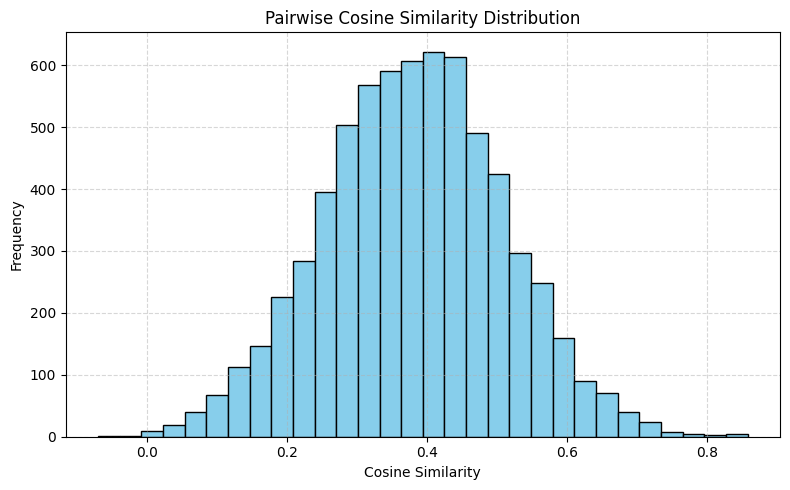

Voice node added with ID 17
Voice node added with ID 18
Finish processing voices
Finish processing segment


In [3]:
video_graph = VideoGraph()
# video_path = "/mnt/bn/videonasi18n/longlin.kylin/vlm-agent-benchmarking/data/videos/raw/720p/5 Poor People vs 1 Secret Millionaire.mp4"
video_path = "data/videos/clipped/5 Poor People vs 1 Secret Millionaire"

streaming_process_video(
    video_graph, video_path, interval_seconds=60, fps=5, segment_limit=10
)

In [4]:
print(len(video_graph.text_nodes))
print(video_graph.edges)
print(video_graph.nodes)

0
{}
{0: <videograph.VideoGraph.Node object at 0x7ffa64ecb940>, 1: <videograph.VideoGraph.Node object at 0x7ff92e0e9d00>, 2: <videograph.VideoGraph.Node object at 0x7ffa64ef56a0>, 3: <videograph.VideoGraph.Node object at 0x7ffa64d2f130>, 4: <videograph.VideoGraph.Node object at 0x7ffa64cd5610>, 5: <videograph.VideoGraph.Node object at 0x7ffa64d40520>, 6: <videograph.VideoGraph.Node object at 0x7ffa64cfbb20>, 7: <videograph.VideoGraph.Node object at 0x7ffa64c2a070>, 8: <videograph.VideoGraph.Node object at 0x7ffa64c2a2e0>, 9: <videograph.VideoGraph.Node object at 0x7ffa64bcfe20>, 10: <videograph.VideoGraph.Node object at 0x7ffa64bcf400>, 11: <videograph.VideoGraph.Node object at 0x7ffa64be15e0>, 12: <videograph.VideoGraph.Node object at 0x7ffa64bf8b80>, 13: <videograph.VideoGraph.Node object at 0x7ffa64be1730>, 14: <videograph.VideoGraph.Node object at 0x7ffa64cdc160>, 15: <videograph.VideoGraph.Node object at 0x7ffa64b448e0>, 16: <videograph.VideoGraph.Node object at 0x7ffa64a56fd0>, 1

In [5]:
# from retrieve import retrieve_from_videograph
from videograph import VideoGraph
from utils.chat_api import (
    generate_messages,
    get_response_with_retry,
    parallel_get_embedding,
)
from utils.general import validate_and_fix_python_list
from prompts import prompt_memory_retrieval

MAX_RETRIES = 3


def generate_queries(question, existing_knowledge=None, query_num=1):
    input = [
        {
            "type": "text",
            "content": prompt_memory_retrieval.format(
                question=question,
                query_num=query_num,
                existing_knowledge=existing_knowledge,
            ),
        }
    ]
    messages = generate_messages(input)
    model = "gpt-4o-2024-11-20"
    queries = None
    for i in range(MAX_RETRIES):
        print(f"Generating queries {i} times")
        queries = get_response_with_retry(model, messages)[0]
        queries = validate_and_fix_python_list(queries)
        if queries is not None:
            break
    if queries is None:
        raise Exception("Failed to generate queries")
    return queries


def retrieve_from_videograph(videograph, question, topk=3):
    queries = generate_queries(question)
    print(f"Queries: {queries}")

    model = "text-embedding-3-large"
    query_embeddings = parallel_get_embedding(model, queries)[0]

    related_nodes = []

    for query_embedding in query_embeddings:
        nodes = videograph.search_text_nodes(query_embedding)
        related_nodes.extend(nodes)

    related_nodes = list(set(related_nodes))
    return related_nodes

question = "Denny"
retrieved_nodes = retrieve_from_videograph(video_graph, question)
print(retrieved_nodes)

Generating queries 0 times


2025-03-25 03:58:10,693 - httpx - INFO - HTTP Request: POST https://search-va.byteintl.net/gpt/openapi/online/v2/crawl/openai/deployments/gpt-4o-2024-11-20/chat/completions?api-version=2024-03-01-preview "HTTP/1.1 200 OK"


Queries: ["Information about Denny's background", 'Key events involving Denny', 'Relationships or interactions Denny has with other characters']
[]
